In [4]:
import os, sys
import numpy as np
sys.path.insert(0, '../fair-classification/disparate_mistreatment/synthetic_data_demo')
sys.path.insert(0, '../fair-classification/fair_classification/')
from generate_synthetic_data import *
import utils as ut
import funcs_disp_mist as fdm
import plot_syn_boundaries as psb
import pandas as pd

In [5]:
def test_synthetic_data():

	""" Generate the synthetic data """
	data_type = 1
	X, y, x_control = generate_synthetic_data(data_type=data_type, plot_data=False) # set plot_data to False to skip the data plot
	sensitive_attrs = list(x_control.keys())

	""" Split the data into train and test """
	train_fold_size = 0.5
	x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

	cons_params = None # constraint parameters, will use them later
	loss_function = "logreg" # perform the experiments with logistic regression
	EPS = 1e-4

	def train_test_classifier():
		w = fdm.train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)

		train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

		
		# accuracy and FPR are for the test because we need of for plotting
		return w, test_score, s_attr_to_fp_fn_test
		

	""" Classify the data while optimizing for accuracy """
	print()
	print("== Unconstrained (original) classifier ==")
	w_uncons, acc_uncons, s_attr_to_fp_fn_test_uncons = train_test_classifier()
	print("\n-----------------------------------------------------------------------------------\n")

	""" Now classify such that we optimize for accuracy while achieving perfect fairness """
	
	print()
	print( "== Classifier with fairness constraint ==")


	print( "\n\n=== Constraints on FPR ===")	# setting parameter for constraints
	cons_type = 1 # FPR constraint -- just change the cons_type, the rest of parameters should stay the same
	tau = 5.0
	mu = 1.2
	sensitive_attrs_to_cov_thresh = {"s1": {0:{0:0, 1:1e-6}, 1:{0:0, 1:1e-6}, 2:{0:0, 1:1e-6}}} # zero covariance threshold, means try to get the fairest solution
	cons_params = {"cons_type": cons_type, 
					"tau": tau, 
					"mu": mu, 
					"sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}

	w_cons, acc_cons, s_attr_to_fp_fn_test_cons  = train_test_classifier()
	psb.plot_boundaries(X, y, x_control, [w_uncons, w_cons], [acc_uncons, acc_cons], [s_attr_to_fp_fn_test_uncons["s1"], s_attr_to_fp_fn_test_cons["s1"]], "img/syn_cons_dtype_%d_cons_type_%d.png"%(data_type, cons_type) )
	print( "\n-----------------------------------------------------------------------------------\n")

	print( "\n\n=== Constraints on FNR ===")
	cons_type = 2
	cons_params["cons_type"] = cons_type # FNR constraint -- just change the cons_type, the rest of parameters should stay the same
	w_cons, acc_cons, s_attr_to_fp_fn_test_cons  = train_test_classifier()
	psb.plot_boundaries(X, y, x_control, [w_uncons, w_cons], [acc_uncons, acc_cons], [s_attr_to_fp_fn_test_uncons["s1"], s_attr_to_fp_fn_test_cons["s1"]], "img/syn_cons_dtype_%d_cons_type_%d.png"%(data_type, cons_type) )
	print( "\n-----------------------------------------------------------------------------------\n")



	print( "\n\n=== Constraints on both FPR and FNR ===")
	cons_type = 4
	cons_params["cons_type"] = cons_type # both FPR and FNR constraints
	w_cons, acc_cons, s_attr_to_fp_fn_test_cons  = train_test_classifier()
	psb.plot_boundaries(X, y, x_control, [w_uncons, w_cons], [acc_uncons, acc_cons], [s_attr_to_fp_fn_test_uncons["s1"], s_attr_to_fp_fn_test_cons["s1"]], "img/syn_cons_dtype_%d_cons_type_%d.png"%(data_type, cons_type) )
	print( "\n-----------------------------------------------------------------------------------\n")


	return


== Unconstrained (original) classifier ==
-1.0    1015
 1.0     985
dtype: int64
-1.0    1013
 1.0     987
dtype: int64
1.0    1024
0.0     976
dtype: int64
0.0
976 976
1.0
1024 1024


Accuracy: 0.797
0.0    1024
1.0     976
dtype: int64
||  s  || FPR. || FNR. ||
0.0
1024 1024
||  0  || 0.30 || 0.26 ||
1.0
976 976
||  1  || 0.08 || 0.16 ||



-----------------------------------------------------------------------------------


== Classifier with fairness constraint ==


=== Constraints on FPR ===
-1.0    1020
 1.0     980
dtype: int64
-1.0    1036
 1.0     964
dtype: int64
1.0    1024
0.0     976
dtype: int64
0.0
976 976
1.0
1024 1024


Accuracy: 0.769
0.0    1024
1.0     976
dtype: int64
||  s  || FPR. || FNR. ||
0.0
1024 1024
||  0  || 0.20 || 0.34 ||
1.0
976 976
||  1  || 0.22 || 0.17 ||




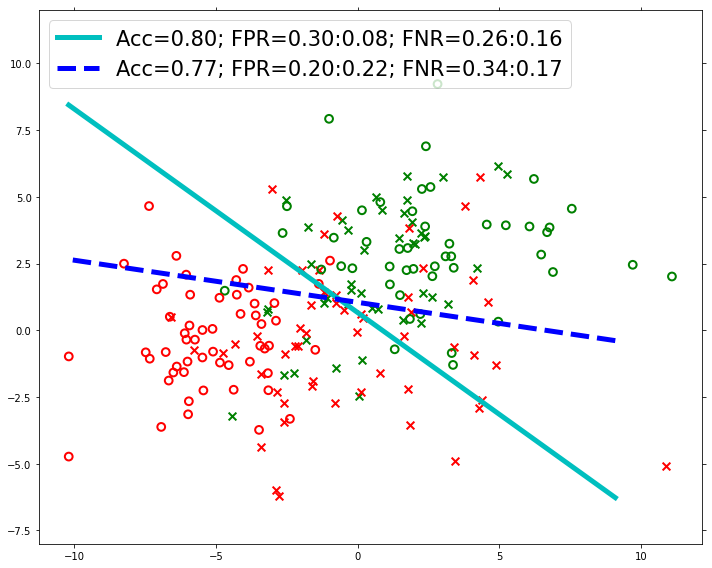


-----------------------------------------------------------------------------------



=== Constraints on FNR ===
 1.0    1157
-1.0     843
dtype: int64
 1.0    1171
-1.0     829
dtype: int64
1.0    1024
0.0     976
dtype: int64
0.0
976 976
1.0
1024 1024


Accuracy: 0.767
0.0    1024
1.0     976
dtype: int64
||  s  || FPR. || FNR. ||
0.0
1024 1024
||  0  || 0.57 || 0.16 ||
1.0
976 976
||  1  || 0.04 || 0.14 ||




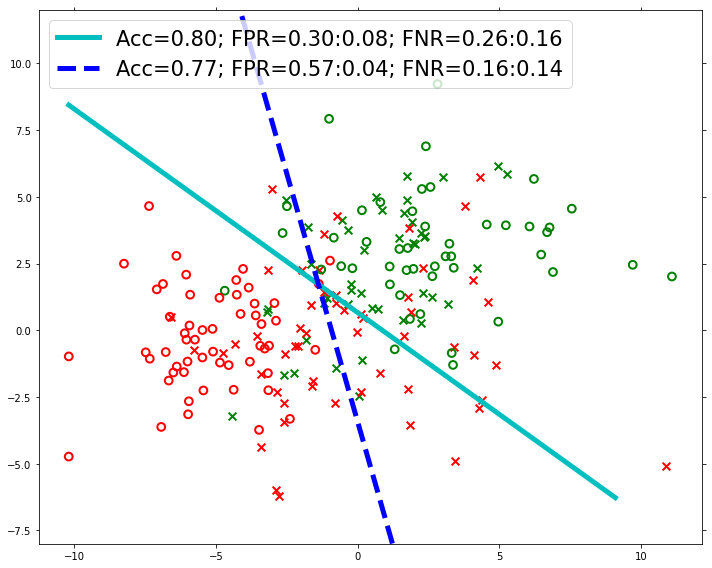


-----------------------------------------------------------------------------------



=== Constraints on both FPR and FNR ===
 1.0    1847
-1.0     153
dtype: int64
 1.0    1825
-1.0     175
dtype: int64
1.0    1024
0.0     976
dtype: int64
0.0
976 976
1.0
1024 1024


Accuracy: 0.595
0.0    1024
1.0     976
dtype: int64
||  s  || FPR. || FNR. ||
0.0
1024 1024
||  0  || 0.80 || 0.00 ||
1.0
976 976
||  1  || 0.84 || 0.00 ||




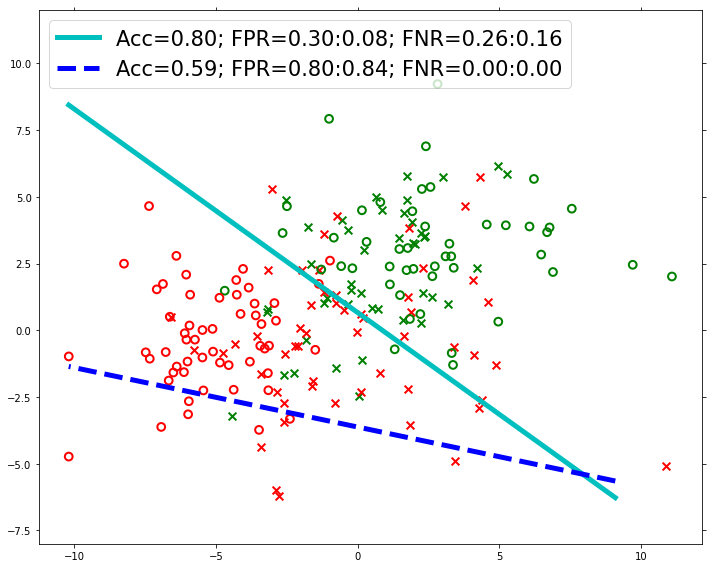


-----------------------------------------------------------------------------------



In [6]:
test_synthetic_data()

In [33]:
data_type = 1
X, y, x_control = generate_synthetic_data(data_type=data_type, plot_data=False) # set plot_data to False to skip the data plot
sensitive_attrs = list(x_control.keys())

""" Split the data into train and test """
train_fold_size = 0.5
x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

cons_params = None # constraint parameters, will use them later
loss_function = "logreg" # perform the experiments with logistic regression
EPS = 1e-4

In [40]:
print(pd.value_counts(x_control_train['s1']))
print("-"*20)
print(pd.value_counts(x_control_test['s1']))

0.0    1014
1.0     986
dtype: int64
--------------------
1.0    1014
0.0     986
dtype: int64


## JOCO DATA ORIG TEST - 1 matrix

In [7]:
from triage import create_engine
import yaml

FILE_PATH = '/mnt/data/experiment_data/peeps/joco_original/matrices'
def read_config_file(config_file):
    config = None
    try:
        with open (config_file, 'r') as file:
            config = yaml.safe_load(file)
    except Exception as e:
        print(e)
        print('Error reading the config file')
    return config


def connect(cred_folder):
    cred_file = os.path.join(cred_folder, 'joco_db_profile.yaml')
    db = read_config_file(cred_file)

    sql_engine = create_engine(
        'postgresql+psycopg2://%s:%s@%s:%i/%s'%(
            db['user'],
            db['pass'],
            db['host'],
            db['port'],
            db['db']
        )
    )
    return sql_engine

conn = connect('../../config')

In [8]:
def load_matrix(matrix_id, entity_to_attrib, demo_col, label_col):
    df = pd.read_csv('%s/%s.csv.gz' % (FILE_PATH, matrix_id), compression='gzip')
    entity_col = []
    entities = df['entity_id'].values
    as_of_dates = df['as_of_date'].values

    for i in range(len(entities)):
        try:
            attr = entity_to_attrib[int(entities[i])]
            entity_col.append(attr)
        except KeyError as e:
            print(e)
            entity_col.append("MISSING")
            
    print("ORIG:"+str(df.shape))
    
    df[demo_col] = entity_col
    df = df[df[demo_col]!='MISSING']
    df[label_col] = 2*(df[label_col] - 0.5)
    
    print("MOD:"+str(df.shape))
    
    return df

def get_matrix_from_df(df, demo_col, label_col):
    exclude_cols = ['entity_id', 'as_of_date', label_col, demo_col]
    x = df[[c for c in df.columns if c not in exclude_cols]].values
    y = df[label_col].values
    x_control = {demo_col:df[demo_col].values}
    
    return x, y, x_control

In [9]:
def get_train_test_matrix_pairs(engine, experiment_hash, model_group_id):
    '''
    args:
        engine: PSQL Connection Engine
        experiment_hash: use the relevant experiment_hash attributing to the train/test matrices you want to obtain
        model_group_id: it might be better to use a model_group_id corresponding to 
        the dummy classifier for which train/test matrices might have been created; otherwise any relevant model_group_id
        will do.
    '''

    query = """
    with rel_models as
    (
        select model_id, model_hash 
        from model_metadata.models
        where 
            built_by_experiment = '%s'
            and model_group_id = %s
    ),
    train_matrices as
    (
        select model_id, matrix_uuid from
        train_results.prediction_metadata
    ),
    test_matrices as 
    (
        select model_id, matrix_uuid from 
        test_results.prediction_metadata
    ),
    matrix_info as 
    (
        select matrix_id, matrix_uuid,
        matrix_type, num_observations
        from model_metadata.matrices
    )
    select 
        rel_models.model_id, 
        train_matrices.matrix_uuid as train_matrix_id,
        test_matrices.matrix_uuid as test_matrix_id,
        m1.matrix_id as train_id, 
        m1.num_observations as train_n_obs,
        m2.matrix_id as test_id,
        m2.num_observations as test_n_obs
    from 
        rel_models, 
        train_matrices, test_matrices,
        matrix_info m1, matrix_info m2
    where
        rel_models.model_id = train_matrices.model_id 
    and
        rel_models.model_id = test_matrices.model_id
    and 
        m1.matrix_uuid = train_matrices.matrix_uuid
    and 
        m2.matrix_uuid = test_matrices.matrix_uuid;
    """%(str(experiment_hash), str(model_group_id))

    #print(query)
    df = pd.read_sql(query, engine)
    print(df.head(2))
    
    vals = df.values
    train_test_matrices = []
    
    for v in vals:
        train_test_matrices.append([(v[1], v[2])])

    return train_test_matrices

In [10]:
entity_to_attrib[100000080]

NameError: name 'entity_to_attrib' is not defined

In [41]:
def get_entity_to_attrib(conn):
    entity_to_attrib = {}
    query = """
    select entity_id, as_of_date, race
    from hemank_bias_alternatives.currmatch_entity_demos
    """
    df = pd.read_sql(query, conn)
    
    entity_ids = df['entity_id'].values
    as_of_dates = df['as_of_date'].values
    races = df['race'].values
    
    for i in range(len(df.values)):
        try:
            as_of_attrib_info = entity_to_attrib[entity_ids[i]]            
        except KeyError as e:
            as_of_attrib_info = {}
            
        as_of_attrib_info[as_of_dates[i]] = races[i]
        entity_to_attrib[entity_ids[i]] = as_of_attrib_info

    return entity_to_attrib

def get_entity_to_attrib_simple(conn):
    entity_to_attrib = {}
    query = """
    select entity_id, race
    from hemank_bias_alternatives.currmatch_entity_demos
    """
    df = pd.read_sql(query, conn)
    entity_ids = df['entity_id'].values
    races = df['race'].values
    
    attrib_info = {}

    for i in range(len(entity_ids)):
        if(races[i]=='W'):
            races[i] = 1
        else:
            races[i] = 0.0
        attrib_info[int(entity_ids[i])] = races[i]
        
    return attrib_info

In [42]:
entity_to_attrib = get_entity_to_attrib_simple(conn)
df_train = load_matrix('cf42d6c89aa0e48384c15088ebc7b289', entity_to_attrib, demo_col, label_col)
df_test = load_matrix('44971539154916ae818762ba67595d33', entity_to_attrib, demo_col, label_col)

100218552
ORIG:(28658, 3468)
MOD:(28657, 3469)
100218552
ORIG:(27908, 3468)
MOD:(27907, 3469)


In [12]:
train_test_matrices = get_train_test_matrix_pairs(conn, '53918b13ea1115d6b5d2b5b16ef4e2f4', 55)
print(train_test_matrices[0])

   model_id                   train_matrix_id  \
0      1182  cf42d6c89aa0e48384c15088ebc7b289   
1      1233  df07e7bc5f1a151d38ff680f16410781   

                     test_matrix_id  \
0  44971539154916ae818762ba67595d33   
1  181d2f2f779c9215b1b78583f2aeae70   

                                            train_id  train_n_obs  \
0  booking_view_warr_bw_1y_binary_2013-04-01 00:0...        28658   
1  booking_view_warr_bw_1y_binary_2013-08-01 00:0...        28335   

                                             test_id  test_n_obs  
0  booking_view_warr_bw_1y_binary_2014-04-01 00:0...       27908  
1  booking_view_warr_bw_1y_binary_2014-08-01 00:0...       27534  
[('cf42d6c89aa0e48384c15088ebc7b289', '44971539154916ae818762ba67595d33')]


In [ ]:
df = pd.read_csv('%s/%s.csv.gz' % (FILE_PATH, train_matrix_uuid), compression='gzip')
df.head()

In [13]:
from importlib import reload
reload(fdm)

<module 'funcs_disp_mist' from '../fair-classification/fair_classification/funcs_disp_mist.py'>

In [44]:
demo_col = 'race'
label_col = 'booking_view_warr_bw_1y'

for i in range(1):
    print("FOR:"+str(i))
    train_matrix_uuid = train_test_matrices[0][0][0]
    test_matrix_uuid = train_test_matrices[0][0][1]
    print("\t\tTRAIN")
    df_train = load_matrix(train_matrix_uuid, entity_to_attrib, demo_col, label_col)
    x_train, y_train, x_control = get_matrix_from_df(df_train, demo_col, label_col)
    print("\t\tTEST")
    df_test = load_matrix(test_matrix_uuid, entity_to_attrib, demo_col, label_col)
    x_test, y_test, x_control_test = get_matrix_from_df(df_test, demo_col, label_col)

FOR:0
		TRAIN
100218552
ORIG:(28658, 3468)
MOD:(28657, 3469)
		TEST
100218552
ORIG:(27908, 3468)
MOD:(27907, 3469)


In [ ]:
test_matrix_uuid = '3f46159319b28e87db57f89e993cbdc5'
df_test = load_matrix(test_matrix_uuid)
print(pd.value_counts(df_test['race_2way']))
x_test = df_test[[c for c in df_test.columns if c not in exclude_cols]].values
y_test = df_test[label_col].values
x_control_test = {demo_col: df_test[demo_col].values}

In [ ]:
print(x_train.shape, df_train.shape)
print(x_test.shape, df_test.shape)

In [18]:
loss_function = "logreg"
EPS = 1e-4
cons_params = None

def train_test_classifier():
    w = fdm.train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)
    train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

    # accuracy and FPR are for the test because we need of for plotting
    return w, test_score, s_attr_to_fp_fn_test

In [19]:
cons_params = None
w_uncons, acc_uncons, s_attr_to_fp_fn_test_uncons = train_test_classifier()

NameError: name 'x_control_train' is not defined

In [62]:
x = x_train
y = y_train
x_control = x_control

max_iters = 150
max_iter_dccp = 75

num_points, num_features = x.shape

import cvxpy

w = cvxpy.Variable(num_features)

np.random.seed(112233)

w.value = np.random.rand(x.shape[1])

constraints = []
loss = cvxpy.sum(  cvxpy.logistic( cvxpy.multiply(-y, x*w) )  ) / num_points
prob = cvxpy.Problem(cvxpy.Minimize(loss), constraints)

tau, mu = 0.005, 1.2

In [ ]:
prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10, solver=cvxpy.ECOS, verbose=True, 
           feastol=EPS, abstol=EPS, reltol=EPS, feastol_inacc=EPS, abstol_inacc=EPS, reltol_inacc=EPS,
          max_iters=max_iters, max_iter=max_iter_dccp)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.721e+04  +2e+05  6e-01  2e+02  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.544e-01  -2.063e+04  +1e+05  2e-01  2e+02  6e-01  6e-01  0.5013  2e-01   2  1  1 |  3  3
 2  +1.055e+00  -1.701e+04  +1e+05  2e-01  1e+02  5e-01  5e-01  0.5013  7e-01   1  2  1 |  9  3
 3  +1.182e+00  -1.496e+04  +8e+04  1e-01  1e+02  4e-01  4e-01  0.9791  9e-01   1  1  1 | 14  0
 4  +1.304e+00  -1.289e+04  +7e+04  1e-01  1e+02  4e-01  4e-01  0.4010  7e-01   2  1  2 |  9  4
 5  +1.385e+00  -1.169e+04  +7e+04  1e-01  9e+01  3e-01  3e-01  0.9791  9e-01   1  1  1 | 15  0
 6  +1.512e+00  -9.733e+03  +6e+04  8e-02  8e+01  3e-01  3e-01  0.4010  6e-01   2  1  1 |  8  4
 7  +1.677e+00  -7.414e+03  +4e+04  6e-02  6e+01  2e-01  2e-01  0.4010  4e-01   2  2  2 |  6  4
 8  +1.832e+00  -5.644e+03  +3e+04  4e-02  4e+

In [22]:
ret_w = np.array(w.value).flatten()

In [23]:
print(pd.value_counts(y_test))

-1.0    24509
 1.0     3398
dtype: int64


In [46]:
x_control_train = {demo_col: x_control}
x_control_test = {demo_col: x_control_test}
sensitive_attrs = list(x_control_train.keys())

In [27]:
sensitive_attrs

['race']

In [61]:
reload(fdm)
train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(ret_w, x_train, y_train, x_control, x_test, y_test, x_control_test, list(sensitive_attrs))

-1.0    27366
 1.0     1291
dtype: int64
-1.0    27301
 1.0      606
dtype: int64
[0.0 0.0 0.0 ... 0.0 0.0 0.0]
<class 'numpy.ndarray'>


Accuracy: 0.868
{'race': array([0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0], dtype=object)}
<class 'dict'>
||  s  || FPR. || FNR. ||


ZeroDivisionError: float division by zero

In [ ]:
s_attr = sensitive_attrs[0]
distances_boundary_test = fdm.get_distance_boundary(ret_w, x_test, x_control_test[s_attr])

In [ ]:
def label_top_k(distances, k):
    sort_df = pd.DataFrame({'dist': distances})
    sort_df.sort_values('dist', ascending=False, inplace=True)
    sort_df['pred_label'] = -1
    sort_df['orig_idx'] = sort_df.index
    sort_df.reset_index(inplace=True)
    i = k-1
    sort_df.loc[:i,'pred_label'] = 1
    sort_df.sort_values('orig_idx', inplace=True)
    return sort_df['pred_label'].values

def calc_prec(pred_label, actual_label):
    label_pos = sum((pred_label == 1).astype(int))
    true_pos = sum(np.logical_and(pred_label == actual_label, pred_label == 1).astype(int))
    return float(true_pos/label_pos)

k = 500

all_class_labels_assigned_test = label_top_k(distances_boundary_test, k)
#all_class_labels_assigned_test = np.sign(distances_boundary_test)

prec_k = calc_prec(all_class_labels_assigned_test, y_test)

print('prec@%s_abs: %.5f' % (k, prec_k))

'''
s_attr_to_fp_fn_test = fdm.get_fpr_fnr_sensitive_features(y_test, all_class_labels_assigned_test, x_control_test, sensitive_attrs, False)

for s_attr in s_attr_to_fp_fn_test.keys():
    for s_val in s_attr_to_fp_fn_test[s_attr].keys():
        s_attr_to_fp_fn_test[s_attr][s_val]['recall'] = 1.000-s_attr_to_fp_fn_test[s_attr][s_val]['fnr']


recall_nonwhite = s_attr_to_fp_fn_test['race_nonwhite'][1]['recall']
recall_white = s_attr_to_fp_fn_test['race_nonwhite'][0]['recall']

print('recall non-white: %.6f' % recall_nonwhite)
print('recall white: %.6f' % recall_white)
print('recall ratio: %.6f' % float(recall_white/recall_nonwhite))
'''